In [1]:
import os, astropy
import numpy as np
import lightkurve as lk
import pbjam as pb
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.units import Quantity, Unit

%matplotlib inline

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
print(f'Lightkurve version {lk.__version__}')
print(f'PBjam version {pb.__version__}')

Lightkurve version 2.4.0
PBjam version 1.0.1


Data downloaded from KASOC.

In [3]:
path = os.path.expanduser("~/OneDrive/Data/alexlyttle/thesis/16cyga")

In [4]:
data = pd.read_table(
    os.path.join(path, "kplr012069424_kasoc-wpsd_slc_v1.pow"),
    names=["freq", "psd"],
    delimiter="\s+",
    comment="#",
    na_values="-Inf",
)
data.head()

,freq,psd
0,0.013242,8.280630
1,0.026485,19.702125
2,0.039727,3.589803
3,0.052970,1.597164
4,0.066212,12.517209


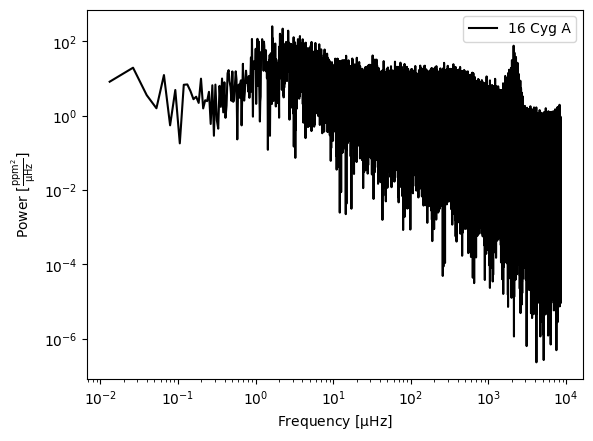

In [30]:
freq_unit = Unit("uHz")
pg = lk.periodogram.Periodogram(
    Quantity(data.freq, unit=freq_unit),
    Quantity(data.psd, unit=Unit("ppm")**2/freq_unit),
    label="16 Cyg A",
)
ax = pg.plot(style="default", color="k")
ax.set_xscale("log")
ax.set_yscale("log");

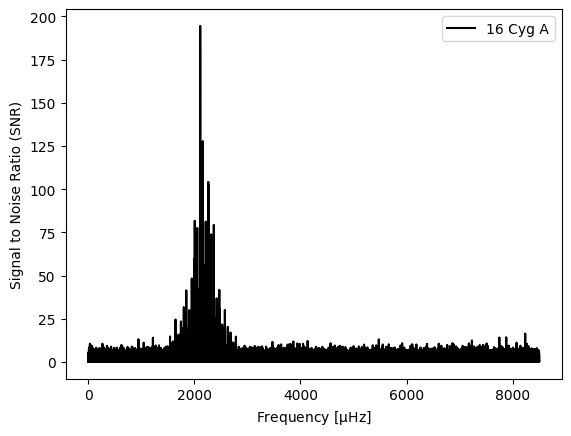

In [27]:
snr = pg.flatten()
snr.plot(style="default", color="k");

In [32]:
nu_max = Quantity(2100.0, unit=freq_unit)
delta_nu = Quantity(103.5, unit=freq_unit)

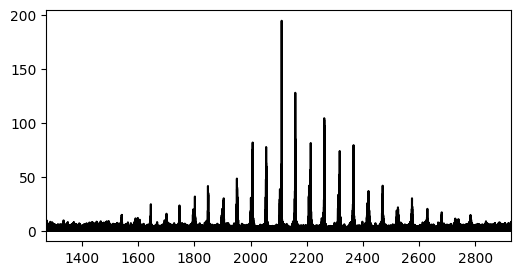

In [28]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(snr.frequency, snr.power, "k")
ax.set_xlim(nu_max-8*delta_nu, nu_max+8*delta_nu);

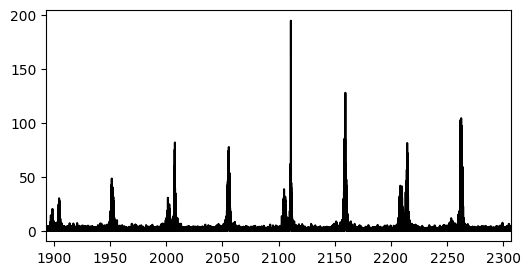

In [29]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(snr.frequency, snr.power, "k")
ax.set_xlim(nu_max-2*delta_nu, nu_max+2*delta_nu);

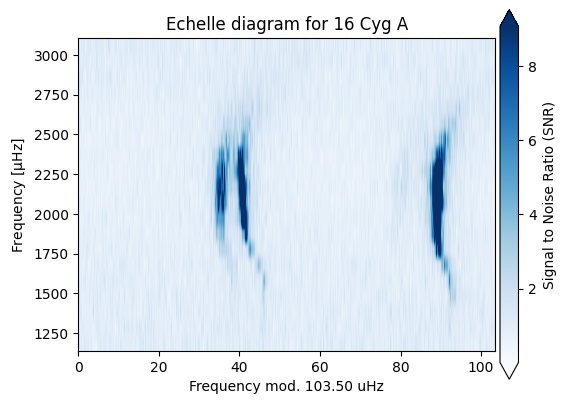

In [33]:
seis = snr.to_seismology()
seis.plot_echelle(delta_nu, nu_max, smooth_filter_width=0.00);

In [36]:
fmin = Quantity(1200., unit=freq_unit)
fmax = Quantity(3000., unit=freq_unit)

fs = np.median(np.diff(snr.frequency))
x0 = int(snr.frequency[0] / fs)

ff = snr.frequency[int(fmin / fs) - x0 : int(fmax / fs) - x0]  # Selected frequency range
pp = snr.power[int(fmin / fs) - x0 : int(fmax / fs) - x0]  # Power range

In [37]:
from scipy.signal import find_peaks

In [41]:
mod_zeros = find_peaks(-1.0 * (ff % delta_nu))[0]
start = mod_zeros[0]
approx_end = mod_zeros[-1]
n_rows = len(mod_zeros) - 1
n_columns = int((approx_end - start) / n_rows)
end = start + n_columns * n_rows
ep = np.reshape(pp[start:end], (n_rows, n_columns))
ef = np.reshape(ff[start:end], (n_rows, n_columns))

In [42]:
fx = (ef[0, :] - ef[0, 0]) % delta_nu
fy = ef[:, 0]

In [121]:
l = np.arange(3)
epsilon = 1.4
ridges = (delta_nu * (l/2 + epsilon - 0.03*l)) % delta_nu

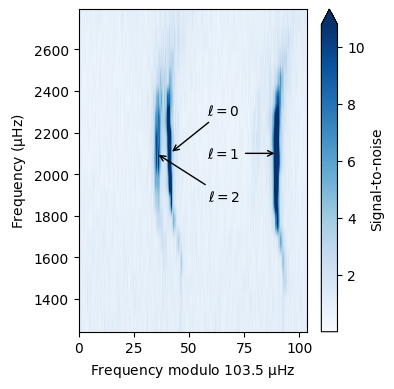

In [153]:
figsize = (4, 4)
extent = (fx[0].value, fx[-1].value, fy[0].value, fy[-1].value)

fig, ax = plt.subplots( figsize=figsize)

vmax = np.nanquantile(ep.value, .99)
cmap = "Blues"

im = ax.imshow(ep.value, cmap=cmap, aspect="auto", extent=extent,
               origin="lower", vmax=vmax)

cbar = fig.colorbar(im, extend="max", ax=ax)
cbar.set_label("Signal-to-noise")

# ax.vlines(ridges.value, fy[0].value, fy[-1].value, color="k", linestyle="--")

arrowprops = dict(arrowstyle="->")
halign = "center"
valign = "center"
ax.annotate(
    r"$\ell=0$", 
    (ridges.value[0], nu_max.value), 
    (((ridges[0]+ridges[1])/2).value, (nu_max+2*delta_nu).value),
    arrowprops=arrowprops,
    horizontalalignment=halign,
    verticalalignment=valign
)
ax.annotate(
    r"$\ell=1$", 
    (ridges.value[1], nu_max.value),
    (((ridges[0]+ridges[1])/2).value, nu_max.value),
    arrowprops=arrowprops,
    horizontalalignment=halign,
    verticalalignment=valign
)
ax.annotate(
    r"$\ell=2$",
    (ridges.value[2], nu_max.value),
    (((ridges[0]+ridges[1])/2).value, (nu_max-2*delta_nu).value),
    arrowprops=arrowprops,
    horizontalalignment=halign,
    verticalalignment=valign
)
        
ax.set_xlabel(f"Frequency modulo {delta_nu.to_string(format='latex_inline')}")
ax.set_ylabel(f"Frequency ({freq_unit.to_string('latex_inline')})")
fig.tight_layout()